## Spatial analysis

### Load packages

In [1]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.feature_selection import mutual_info_regression
from scipy.spatial.transform import Rotation as R
from scipy.optimize import linear_sum_assignment
import itertools
import functools
import networkx as nx
from community import community_louvain
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib.colors as mcolors
import matplotlib
import seaborn as sns
from nilearn import image
import glob
import random
from PyComplexHeatmap import *
from IPython.display import display

### Load regions and labels

In [2]:
labels_lookup = {
    'Left-Lateral-Ventricle': 4,
    'Left-Inf-Lat-Vent': 5,
    'Left-Cerebellum-White-Matter': 7,
    'Left-Cerebellum-Cortex': 8,
    'Left-Thalamus-Proper': 10,
    'Left-Caudate': 11,
    'Left-Putamen': 12,
    'Left-Pallidum': 13,
    'Left-3rd-Ventricle': 14,
    'Left-4th-Ventricle': 15,
    'Left-Brain-Stem': 16,
    'Left-Hippocampus': 17,
    'Left-Amygdala': 18,
    'Left-CSF': 24,
    'Left-Accumbens-area': 26,
    'Left-VentralDC': 28,
    'Left-choroid-plexus': 31,
    'Right-Lateral-Ventricle': 43,
    'Right-Inf-Lat-Vent': 44,
    'Right-Cerebellum-White-Matter': 46,
    'Right-Cerebellum-Cortex': 47,
    'Right-Thalamus-Proper': 49,
    'Right-Caudate': 50,
    'Right-Putamen': 51,
    'Right-Pallidum': 52,
    'Right-Hippocampus': 53,
    'Right-Amygdala': 54,
    'Right-Accumbens-area': 58,
    'Right-VentralDC': 60,
    'Right-choroid-plexus': 63,
    'Right-3rd-Ventricle': 14,
    'Right-4th-Ventricle': 15,
    'Right-Brain-Stem': 16,
    'Right-CSF': 24,
    'ctx-lh-caudalanteriorcingulate': 1002,
    'ctx-lh-caudalmiddlefrontal': 1003,
    'ctx-lh-cuneus': 1005,
    'ctx-lh-entorhinal': 1006,
    'ctx-lh-fusiform': 1007,
    'ctx-lh-inferiorparietal': 1008,
    'ctx-lh-inferiortemporal': 1009,
    'ctx-lh-isthmuscingulate': 1010,
    'ctx-lh-lateraloccipital': 1011,
    'ctx-lh-lateralorbitofrontal': 1012,
    'ctx-lh-lingual': 1013,
    'ctx-lh-medialorbitofrontal': 1014,
    'ctx-lh-middletemporal': 1015,
    'ctx-lh-parahippocampal': 1016,
    'ctx-lh-paracentral': 1017,
    'ctx-lh-parsopercularis': 1018,
    'ctx-lh-parsorbitalis': 1019,
    'ctx-lh-parstriangularis': 1020,
    'ctx-lh-pericalcarine': 1021,
    'ctx-lh-postcentral': 1022,
    'ctx-lh-posteriorcingulate': 1023,
    'ctx-lh-precentral': 1024,
    'ctx-lh-precuneus': 1025,
    'ctx-lh-rostralanteriorcingulate': 1026,
    'ctx-lh-rostralmiddlefrontal': 1027,
    'ctx-lh-superiorfrontal': 1028,
    'ctx-lh-superiorparietal': 1029,
    'ctx-lh-superiortemporal': 1030,
    'ctx-lh-supramarginal': 1031,
    'ctx-lh-transversetemporal': 1034,
    'ctx-lh-insula': 1035,
    'ctx-rh-caudalanteriorcingulate': 2002,
    'ctx-rh-caudalmiddlefrontal': 2003,
    'ctx-rh-cuneus': 2005,
    'ctx-rh-entorhinal': 2006,
    'ctx-rh-fusiform': 2007,
    'ctx-rh-inferiorparietal': 2008,
    'ctx-rh-inferiortemporal': 2009,
    'ctx-rh-isthmuscingulate': 2010,
    'ctx-rh-lateraloccipital': 2011,
    'ctx-rh-lateralorbitofrontal': 2012,
    'ctx-rh-lingual': 2013,
    'ctx-rh-medialorbitofrontal': 2014,
    'ctx-rh-middletemporal': 2015,
    'ctx-rh-parahippocampal': 2016,
    'ctx-rh-paracentral': 2017,
    'ctx-rh-parsopercularis': 2018,
    'ctx-rh-parsorbitalis': 2019,
    'ctx-rh-parstriangularis': 2020,
    'ctx-rh-pericalcarine': 2021,
    'ctx-rh-postcentral': 2022,
    'ctx-rh-posteriorcingulate': 2023,
    'ctx-rh-precentral': 2024,
    'ctx-rh-precuneus': 2025,
    'ctx-rh-rostralanteriorcingulate': 2026,
    'ctx-rh-rostralmiddlefrontal': 2027,
    'ctx-rh-superiorfrontal': 2028,
    'ctx-rh-superiorparietal': 2029,
    'ctx-rh-superiortemporal': 2030,
    'ctx-rh-supramarginal': 2031,
    'ctx-rh-transversetemporal': 2034,
    'ctx-rh-insula': 2035,
    'WM-hypointensities': 77
}

new_keys = [n.lower() for n in labels_lookup.keys()]
labels_lookup = {k:v for k,v in zip(new_keys, labels_lookup.values())}

In [3]:
regions_of_interest_76 = {
    'limbic system': [
        'left-hippocampus', 'right-hippocampus',
        'left-amygdala', 'right-amygdala',
        'ctx-lh-entorhinal', 'ctx-rh-entorhinal',
        'ctx-lh-parahippocampal', 'ctx-rh-parahippocampal',
        'ctx-lh-isthmuscingulate', 'ctx-rh-isthmuscingulate',
        'ctx-lh-posteriorcingulate', 'ctx-rh-posteriorcingulate'
    ],

    'temporal lobe': [
        'ctx-lh-transversetemporal', 'ctx-rh-transversetemporal',
        'ctx-lh-superiortemporal', 'ctx-rh-superiortemporal',
        'ctx-lh-middletemporal', 'ctx-rh-middletemporal',
        'ctx-lh-inferiortemporal', 'ctx-rh-inferiortemporal',
        'ctx-lh-fusiform', 'ctx-rh-fusiform'
    ],

    'insula': [
        'ctx-lh-insula', 'ctx-rh-insula'
    ],

    'parietal lobe': [
        'ctx-lh-postcentral', 'ctx-rh-postcentral',
        'ctx-lh-paracentral', 'ctx-rh-paracentral',
        'ctx-lh-superiorparietal', 'ctx-rh-superiorparietal',
        'ctx-lh-inferiorparietal', 'ctx-rh-inferiorparietal',
        'ctx-lh-supramarginal', 'ctx-rh-supramarginal',
        'ctx-lh-precuneus', 'ctx-rh-precuneus'
    ],

    "basal ganglia": [
        'left-accumbens-area', 'right-accumbens-area',
        'left-caudate', 'right-caudate',
        'left-pallidum', 'right-pallidum',
        'left-putamen', 'right-putamen',
        'left-thalamus', 'right-thalamus'
    ],

    'frontal lobe': [
        'ctx-lh-rostralanteriorcingulate', 'ctx-rh-rostralanteriorcingulate',
        'ctx-lh-caudalanteriorcingulate', 'ctx-rh-caudalanteriorcingulate',
        'ctx-lh-medialorbitofrontal', 'ctx-rh-medialorbitofrontal',
        'ctx-lh-lateralorbitofrontal', 'ctx-rh-lateralorbitofrontal',
        'ctx-lh-rostralmiddlefrontal', 'ctx-rh-rostralmiddlefrontal',
        'ctx-lh-superiorfrontal', 'ctx-rh-superiorfrontal',
        'ctx-lh-parsorbitalis', 'ctx-rh-parsorbitalis',
        'ctx-lh-parsopercularis', 'ctx-rh-parsopercularis',
        'ctx-lh-parstriangularis', 'ctx-rh-parstriangularis',
        'ctx-lh-caudalmiddlefrontal', 'ctx-rh-caudalmiddlefrontal',
        'ctx-lh-precentral', 'ctx-rh-precentral'
    ],

    'occipital lobe': [
        'ctx-lh-cuneus', 'ctx-rh-cuneus',
        'ctx-lh-lateraloccipital', 'ctx-rh-lateraloccipital',
        'ctx-lh-lingual', 'ctx-rh-lingual',
        'ctx-lh-pericalcarine', 'ctx-rh-pericalcarine'
    ]
}

regions_of_interest_76 = {k:list(map(str.lower, v)) for k,v in regions_of_interest_76.items()}
regions_order_76 = functools.reduce(lambda a,b:a+b, regions_of_interest_76.values())
region_label_dict_76 = {k:v for d in [{vv:k for vv in v} for k,v in regions_of_interest_76.items()] for k,v in d.items()}

In [4]:
regions_of_interest_64 = {
    
        'medtemp': ['CTX_LH_ENTORHINAL', 'CTX_RH_ENTORHINAL', 'LEFT_HIPPOCAMPUS', 'RIGHT_HIPPOCAMPUS', 'LEFT_AMYGDALA', 'RIGHT_AMYGDALA', 'CTX_LH_PARAHIPPOCAMPAL', 'CTX_RH_PARAHIPPOCAMPAL'],

        'lattemp': ['CTX_LH_INFERIORTEMPORAL', 'CTX_RH_INFERIORTEMPORAL', 'CTX_LH_FUSIFORM', 'CTX_RH_FUSIFORM', 
                                'CTX_LH_MIDDLETEMPORAL', 'CTX_RH_MIDDLETEMPORAL', 
                                'CTX_LH_SUPERIORTEMPORAL', 'CTX_RH_SUPERIORTEMPORAL',
                                'CTX_LH_TRANSVERSETEMPORAL', 'CTX_RH_TRANSVERSETEMPORAL'],

        'medpar': ['CTX_LH_ISTHMUSCINGULATE', 'CTX_RH_ISTHMUSCINGULATE', 'CTX_LH_POSTERIORCINGULATE', 'CTX_RH_POSTERIORCINGULATE', 'CTX_LH_PRECUNEUS', 'CTX_RH_PRECUNEUS'],
        'latpar': ['CTX_LH_INFERIORPARIETAL', 'CTX_RH_INFERIORPARIETAL', 'CTX_LH_SUPERIORPARIETAL', 'CTX_RH_SUPERIORPARIETAL', 'CTX_LH_SUPRAMARGINAL', 'CTX_RH_SUPRAMARGINAL', 'CTX_LH_POSTCENTRAL', 'CTX_RH_POSTCENTRAL'],

        'front': ['CTX_LH_CAUDALANTERIORCINGULATE', 'CTX_RH_CAUDALANTERIORCINGULATE',
                                'CTX_LH_CAUDALMIDDLEFRONTAL', 'CTX_RH_CAUDALMIDDLEFRONTAL',
                                'CTX_LH_LATERALORBITOFRONTAL', 'CTX_RH_LATERALORBITOFRONTAL',
                                'CTX_LH_MEDIALORBITOFRONTAL', 'CTX_RH_MEDIALORBITOFRONTAL',
                                'CTX_LH_PARSOPERCULARIS', 'CTX_RH_PARSOPERCULARIS',
                                'CTX_LH_PARSORBITALIS', 'CTX_RH_PARSORBITALIS',
                                'CTX_LH_PARSTRIANGULARIS', 'CTX_RH_PARSTRIANGULARIS',
                                'CTX_LH_PRECENTRAL', 'CTX_RH_PRECENTRAL',
                                'CTX_LH_ROSTRALANTERIORCINGULATE', 'CTX_RH_ROSTRALANTERIORCINGULATE',
                                'CTX_LH_ROSTRALMIDDLEFRONTAL', 'CTX_RH_ROSTRALMIDDLEFRONTAL',
                                'CTX_LH_SUPERIORFRONTAL', 'CTX_RH_SUPERIORFRONTAL',
                                'CTX_LH_INSULA', 'CTX_RH_INSULA'],
        
        'occ' : ['CTX_LH_LATERALOCCIPITAL', 'CTX_RH_LATERALOCCIPITAL',
                        'CTX_LH_LINGUAL', 'CTX_RH_LINGUAL',
                        'CTX_LH_PERICALCARINE', 'CTX_RH_PERICALCARINE',
                        'CTX_LH_CUNEUS', 'CTX_RH_CUNEUS']

        }

regions_of_interest_64 = {k:list(map(str.lower, v)) for k,v in regions_of_interest_64.items()}
regions_of_interest_64 = {
    key: [val.replace("_", "-") for val in value] 
    for key, value in regions_of_interest_64.items()
}
regions_order_64 = functools.reduce(lambda a,b:a+b, regions_of_interest_64.values())
region_label_dict_64 = {k:v for d in [{vv:k for vv in v} for k,v in regions_of_interest_64.items()] for k,v in d.items()}

In [5]:
regions_of_interest = {key: [v for v in value if v in regions_order_64] for key, value in regions_of_interest_76.items()}
regions_of_interest = {key: value for key, value in regions_of_interest.items() if len(value)!=0}
regions_order = functools.reduce(lambda a,b:a+b, regions_of_interest.values())
region_label_dict = {k:v for d in [{vv:k for vv in v} for k,v in regions_of_interest.items()] for k,v in d.items()}
lobe_order = ['limbic system','temporal lobe','insula','parietal lobe','frontal lobe','occipital lobe']

In [6]:
pathways = {
    'Stage I-II': [
    'CTX_LH_ENTORHINAL', 
    'CTX_RH_ENTORHINAL', 
    'LEFT_HIPPOCAMPUS', 
    'RIGHT_HIPPOCAMPUS'],
    
    'Stage III': [
    'LEFT_AMYGDALA', 
    'RIGHT_AMYGDALA',
    'CTX_LH_PARAHIPPOCAMPAL', 
    'CTX_RH_PARAHIPPOCAMPAL',
    'CTX_LH_FUSIFORM', 
    'CTX_RH_FUSIFORM',
    'CTX_LH_LINGUAL', 
    'CTX_RH_LINGUAL'],

    'Stage IV': [
    'CTX_LH_INFERIORTEMPORAL',
    'CTX_RH_INFERIORTEMPORAL',
    'CTX_LH_MIDDLETEMPORAL',
    'CTX_RH_MIDDLETEMPORAL',
    'CTX_LH_INSULA',
    'CTX_RH_INSULA',
    'CTX_LH_POSTERIORCINGULATE',
    'CTX_RH_POSTERIORCINGULATE',
    'CTX_LH_ISTHMUSCINGULATE',
    'CTX_RH_ISTHMUSCINGULATE',
    'CTX_LH_CAUDALANTERIORCINGULATE',
    'CTX_RH_CAUDALANTERIORCINGULATE',
    'CTX_LH_ROSTRALANTERIORCINGULATE',
    'CTX_RH_ROSTRALANTERIORCINGULATE'], 

    'Stage V': [
    'CTX_LH_SUPERIORTEMPORAL', 
    'CTX_RH_SUPERIORTEMPORAL',
    'CTX_LH_TRANSVERSETEMPORAL', 
    'CTX_RH_TRANSVERSETEMPORAL',
    'CTX_LH_INFERIORPARIETAL', 
    'CTX_RH_INFERIORPARIETAL',
    'CTX_LH_SUPRAMARGINAL', 
    'CTX_RH_SUPRAMARGINAL',
    'CTX_LH_PRECUNEUS', 
    'CTX_RH_PRECUNEUS',
    'CTX_LH_SUPERIORPARIETAL', 
    'CTX_RH_SUPERIORPARIETAL',
    'CTX_LH_LATERALOCCIPITAL', 
    'CTX_RH_LATERALOCCIPITAL',
    'CTX_LH_LATERALORBITOFRONTAL', 
    'CTX_RH_LATERALORBITOFRONTAL', 
    'CTX_LH_MEDIALORBITOFRONTAL', 
    'CTX_RH_MEDIALORBITOFRONTAL',
    'CTX_LH_PARSOPERCULARIS', 
    'CTX_RH_PARSOPERCULARIS',
    'CTX_LH_PARSORBITALIS',
    'CTX_RH_PARSORBITALIS',
    'CTX_LH_PARSTRIANGULARIS', 
    'CTX_RH_PARSTRIANGULARIS',
    'CTX_LH_CAUDALMIDDLEFRONTAL',
    'CTX_RH_CAUDALMIDDLEFRONTAL',
    'CTX_LH_ROSTRALMIDDLEFRONTAL',
    'CTX_RH_ROSTRALMIDDLEFRONTAL',
    'CTX_LH_SUPERIORFRONTAL',
    'CTX_RH_SUPERIORFRONTAL'],

    'Stage VI': [
    'CTX_LH_POSTCENTRAL', 
    'CTX_RH_POSTCENTRAL',
    'CTX_LH_PRECENTRAL', 
    'CTX_RH_PRECENTRAL',
    'CTX_LH_CUNEUS', 
    'CTX_RH_CUNEUS',
    'CTX_LH_PERICALCARINE',
    'CTX_RH_PERICALCARINE',]
}

In [7]:
new_names = {
    'Stage I-II': [
    'CTX_LH_ENTORHINAL', 
    'CTX_RH_ENTORHINAL', 
    'LEFT_HIPPOCAMPUS', 
    'RIGHT_HIPPOCAMPUS'],
    
    'Stage III': [
    'LEFT_AMYGDALA', 
    'RIGHT_AMYGDALA',
    'CTX_LH_PARAHIPPOCAMPAL', 
    'CTX_RH_PARAHIPPOCAMPAL',
    'CTX_LH_FUSIFORM', 
    'CTX_RH_FUSIFORM',
    'CTX_LH_LINGUAL', 
    'CTX_RH_LINGUAL'],

    'Stage IV': [
    'CTX_LH_INFERIOR_TEMPORAL',
    'CTX_RH_INFERIOR_TEMPORAL',
    'CTX_LH_MIDDLE_TEMPORAL',
    'CTX_RH_MIDDLE_TEMPORAL',
    'CTX_LH_INSULA',
    'CTX_RH_INSULA',
    'CTX_LH_POSTERIOR_CINGULATE',
    'CTX_RH_POSTERIOR_CINGULATE',
    'CTX_LH_ISTHMUS_CINGULATE',
    'CTX_RH_ISTHMUS_CINGULATE',
    'CTX_LH_CAUDAL_ANTERIOR_CINGULATE',
    'CTX_RH_CAUDAL_ANTERIOR_CINGULATE',
    'CTX_LH_ROSTRAL_ANTERIOR_CINGULATE',
    'CTX_RH_ROSTRAL_ANTERIOR_CINGULATE'], 

    'Stage V': [
    'CTX_LH_SUPERIOR_TEMPORAL', 
    'CTX_RH_SUPERIOR_TEMPORAL',
    'CTX_LH_TRANSVERSE_TEMPORAL', 
    'CTX_RH_TRANSVERSE_TEMPORAL',
    'CTX_LH_INFERIOR_PARIETAL', 
    'CTX_RH_INFERIOR_PARIETAL',
    'CTX_LH_SUPRAMARGINAL', 
    'CTX_RH_SUPRAMARGINAL',
    'CTX_LH_PRECUNEUS', 
    'CTX_RH_PRECUNEUS',
    'CTX_LH_SUPERIOR_PARIETAL', 
    'CTX_RH_SUPERIOR_PARIETAL',
    'CTX_LH_LATERAL_OCCIPITAL', 
    'CTX_RH_LATERAL_OCCIPITAL',
    'CTX_LH_LATERAL_ORBITOFRONTAL', 
    'CTX_RH_LATERAL_ORBITOFRONTAL', 
    'CTX_LH_MEDIAL_ORBITOFRONTAL', 
    'CTX_RH_MEDIAL_ORBITOFRONTAL',
    'CTX_LH_PARS_OPERCULARIS', 
    'CTX_RH_PARS_OPERCULARIS',
    'CTX_LH_PARS_ORBITALIS',
    'CTX_RH_PARS_ORBITALIS',
    'CTX_LH_PARS_TRIANGULARIS', 
    'CTX_RH_PARS_TRIANGULARIS',
    'CTX_LH_CAUDAL_MIDDLE_FRONTAL',
    'CTX_RH_CAUDAL_MIDDLE_FRONTAL',
    'CTX_LH_ROSTRAL_MIDDLE_FRONTAL',
    'CTX_RH_ROSTRAL_MIDDLE_FRONTAL',
    'CTX_LH_SUPERIOR_FRONTAL',
    'CTX_RH_SUPERIOR_FRONTAL'],

    'Stage VI': [
    'CTX_LH_POSTCENTRAL', 
    'CTX_RH_POSTCENTRAL',
    'CTX_LH_PRECENTRAL', 
    'CTX_RH_PRECENTRAL',
    'CTX_LH_CUNEUS', 
    'CTX_RH_CUNEUS',
    'CTX_LH_PERICALCARINE',
    'CTX_RH_PERICALCARINE',]
}

In [8]:
pathways = {k:list(map(str.lower, v)) for k,v in pathways.items()}
pathways = {
    key: [val.replace("_", "-") for val in value] 
    for key, value in pathways.items()
}
pathways_order = functools.reduce(lambda a,b:a+b, pathways.values())
region_stage_dict = {k:v for d in [{vv:k for vv in v} for k,v in pathways.items()] for k,v in d.items()}
stage_order = list(pathways.keys())

In [9]:
newnames_pathways = {k:list(map(str.lower, v)) for k,v in new_names.items()}
newnames_pathways = {
    key: [val.replace("_", "-") for val in value] 
    for key, value in newnames_pathways.items()
}
newnames_pathways_order = functools.reduce(lambda a,b:a+b, newnames_pathways.values())
newnames = [idx.replace('-',' ') for idx in [idx if idx[:4]!='ctx-' else idx[4:] for idx in [idx.replace('rh-','right-') for idx in [idx.replace('lh-','left-') for idx in newnames_pathways_order]]]]
names_mapping = {n1:n2 for n1,n2 in zip(pathways_order, newnames)}

### Functions: mutual information matrix calculation, community detection

In [10]:
def entropy_continuous(x, bins='auto'):
    hist, bin_edges = np.histogram(x, bins=bins, density=True)
    probs = hist / np.sum(hist)
    probs = probs[probs > 0]
    return -np.sum(probs * np.log(probs))

In [11]:
def get_nmi_matrix(path, name, regions_order, threshold=None, save_mi=True):
    
    # read shap and ground truth values
    df_tau = pd.read_csv(path, index_col='ID')
    df_tau.index = df_tau.index.astype(str)
    df_tau.columns = df_tau.columns.str.lower()
    df_tau = df_tau[(df_tau[f'tau_{name}_label_label']==1)&(df_tau[f'tau_{name}_label_prob']>=label_threshold[name])]

    df_shap = df_tau.filter(like='_volume')
    df_shap.columns = ['-'.join(c.split('_')[1:-1]) for c in df_shap.columns]
    df_shap = df_shap[[c for c in df_shap.columns if c in regions_order]]
    df_shap = df_shap[regions_order]

    df_gt = df_tau.filter(like='_suvr')
    df_gt.columns = ['-'.join(c.split('_')[1:-1]) for c in df_gt.columns]
    df_gt = df_gt[[c for c in df_gt.columns if c in regions_order]]
    df_gt = df_gt[regions_order]

    assert set(df_shap.columns)==set(df_gt.columns), "Inconsistent regions in shap and ground truth."
    
    # compute mutual information
    pairs = list(itertools.combinations(df_shap.columns,2))
    nmis_shap = []
    nmis_gt = []
    
    for r1,r2 in pairs:
        
        mi_shap = mutual_info_regression(df_shap[[r1]], df_shap[r2])[0]    # symmetry verified
        h1_shap = entropy_continuous(df_shap[[r1]])
        h2_shap = entropy_continuous(df_shap[[r2]])
        nmi_shap = mi_shap/np.sqrt(h1_shap*h2_shap)

        mi_gt = mutual_info_regression(df_gt[[r1]], df_gt[r2])[0]
        h1_gt = entropy_continuous(df_gt[[r1]])
        h2_gt = entropy_continuous(df_gt[[r2]])
        nmi_gt = mi_gt/np.sqrt(h1_gt*h2_gt)

        nmis_shap.append(nmi_shap)
        nmis_gt.append(nmi_gt)
    
    # generate mutual information matrix (n_region x n_region)
    regions = list(df_shap.columns)
    n_region = len(regions)
    df_mi_shap = pd.DataFrame(np.ones((n_region,n_region)), columns=regions, index=regions)
    df_mi_gt = pd.DataFrame(np.ones((n_region,n_region)), columns=regions, index=regions)
    for i in range(len(pairs)):
        r1,r2 = pairs[i]
        df_mi_shap.loc[r1,r2] = nmis_shap[i]
        df_mi_shap.loc[r2,r1] = nmis_shap[i]
        df_mi_gt.loc[r1,r2] = nmis_gt[i]
        df_mi_gt.loc[r2,r1] = nmis_gt[i]
    
    # apply threshold if specified
    if threshold is not None:
        df_mi_shap = df_mi_shap.map(lambda x: 0 if x < threshold else x)
        df_mi_gt = df_mi_gt.map(lambda x: 0 if x < threshold else x)
    
    if save_mi:
        df_mi_shap.to_csv(f'tau_nmi/{name}_shap.csv')
        df_mi_gt.to_csv(f'tau_nmi/{name}_gt.csv')
    
    return df_mi_shap, df_mi_gt

In [12]:
def run_louvain_multiple_times(G, num_runs=100, base_seed=42):
    partitions = []
    seeds = []
    random.seed(base_seed)
    for _ in range(num_runs):
        seed = random.randint(0, 2**32 - 1)
        seeds.append(seed)
        random.seed(seed)
    for seed in seeds:
        partition = community_louvain.best_partition(G, random_state=seed)
        partitions.append(partition)
    return partitions

def create_coassociation_matrix(partitions, num_nodes):
    coassoc_matrix = np.zeros((num_nodes, num_nodes))
    for partition in partitions:
        for i in range(num_nodes):
            for j in range(num_nodes):
                if partition[i] == partition[j]:
                    coassoc_matrix[i][j] += 1
    coassoc_matrix /= len(partitions)
    return coassoc_matrix

def get_consensus_partition(df_mi, name, num_runs=100, threshold=4, base_seed=42, save_community=True):
    
    G = nx.from_numpy_array(df_mi.values)
    num_nodes = len(G.nodes)
    partitions = run_louvain_multiple_times(G, num_runs, base_seed=base_seed)
    coassoc_matrix = create_coassociation_matrix(partitions, num_nodes)
    
    Z = linkage(coassoc_matrix, method='average')
    consensus_labels = fcluster(Z, t=threshold, criterion='distance')
    
    if save_community:
        pd.DataFrame({'community':consensus_labels}, index=df_mi.index).to_csv(f'tau_community/{name}.csv')

    return consensus_labels

### Generate communities

In [13]:
label_threshold = {
    'front': 0.3677754921396508,
    'occ': 0.3840338706695053,
    'medtemp': 0.29693878203988056,
    'lattemp': 0.3436502326571356,
    'medpar': 0.3982229087997851,
    'latpar': 0.38482059194816703,
}

In [16]:
# calculate NMI and generate communities

paths = glob.glob('/projectnb/vkolagrp/varuna/mri_pet/shap_analysis/data_files/0306/*.csv')
th_shap = {'medtemp':2.8, 'lattemp':2.9, 'medpar':2.6, 'latpar':2.9, 'front':2.8, 'occ':3.2}
th_gt = {'medtemp':3.2, 'lattemp':3.3, 'medpar':2.6, 'latpar':3.2, 'front':2.3, 'occ':3.6}

for p in paths:
    name = p.split('/')[-1].split('_')[0]
    df_mi_shap = pd.read_csv(f'tau_nmi/{name}_shap.csv', index_col=0)
    df_mi_gt = pd.read_csv(f'tau_nmi/{name}_gt.csv', index_col=0)
    _ = get_consensus_partition(df_mi_shap, name+'_shap', threshold=th_shap[name])
    _ = get_consensus_partition(df_mi_gt, name+'_gt', threshold=th_gt[name])

In [14]:
# load communities

label_order = ['medtemp', 'lattemp', 'medpar', 'latpar', 'front', 'occ']
label_names = ['med-temp', 'lat-temp', 'med-par', 'lat-par', 'frontal', 'occipital']
label_name_map_dict = {k:v for k,v in zip(label_order, label_names)}
community_dfs_shap = [pd.read_csv(f'tau_community_fixed_size/{l}_shap.csv', index_col=0) for l in label_order]
community_dfs_gt = [pd.read_csv(f'tau_community_fixed_size/{l}_gt.csv', index_col=0) for l in label_order]

In [15]:
# reorder communities by size

for i in range(len(label_order)):
    count_dict1 = community_dfs_shap[i]['community'].value_counts().to_dict()
    count_dict1 = dict(sorted(count_dict1.items(), key=lambda item: item[1], reverse=True))
    new_comm_order1 = list(count_dict1.keys())
    m1 = {k:v for k,v in zip(new_comm_order1,range(1,len(new_comm_order1)+1))}
    community_dfs_shap[i]['community'] = community_dfs_shap[i]['community'].replace(m1)

    count_dict2 = community_dfs_gt[i]['community'].value_counts().to_dict()
    count_dict2 = dict(sorted(count_dict2.items(), key=lambda item: item[1], reverse=True))
    new_comm_order2 = list(count_dict2.keys())
    m2 = {k:v for k,v in zip(new_comm_order2,range(1,len(new_comm_order2)+1))}
    community_dfs_gt[i]['community'] = community_dfs_gt[i]['community'].replace(m2)

### Permuation test

In [16]:
def get_rotation_matrix(theta, axis):
    
    theta = np.radians(theta)
    c, s = np.cos(theta), np.sin(theta)
    
    if axis == 'x':
        R = np.array([[1, 0, 0],
                      [0, c, -s],
                      [0, s, c]])
    elif axis == 'y':
        R = np.array([[c, 0, s],
                      [0, 1, 0],
                      [-s, 0, c]])
    elif axis == 'z':
        R = np.array([[c, -s, 0],
                      [s, c, 0],
                      [0, 0, 1]])
    else:
        raise ValueError("Axis must be 'x', 'y', or 'z'")
    
    return R

In [17]:
def spatial_permutation(region_centers, region_labels, theta):

    Rx = get_rotation_matrix(theta[0], 'x')
    Ry = get_rotation_matrix(theta[1], 'y')
    Rz = get_rotation_matrix(theta[2], 'z')
    rotated_centers = region_centers @ (Rz @ Ry @ Rx).T 
    distance_matrix = np.linalg.norm(rotated_centers[:, None, :] - region_centers[None, :, :], axis=-1)
    _, col_ind = linear_sum_assignment(distance_matrix)
    permuted_labels = region_labels[col_ind]
    
    return permuted_labels


def spatial_permutation_test(shap_labels, path_labels, region_centers, angle_range=(0,360), n_permutations=5000, seed=42):

    observed_ami = adjusted_mutual_info_score(shap_labels, path_labels)
    permuted_amis = []

    np.random.seed(seed=seed)
    thetas = np.random.uniform(*angle_range, size=(n_permutations,3))
    
    for i in range(n_permutations):
        seed = np.random.randint(0, 2**32)
        permuted_labels = spatial_permutation(region_centers, shap_labels, thetas[i])
        permuted_ami = adjusted_mutual_info_score(permuted_labels, path_labels)
        permuted_amis.append(permuted_ami)
    
    p_value = np.mean(np.array(permuted_amis) >= observed_ami)
    return observed_ami, p_value

In [18]:
# get projected region centroids

nii_img = image.load_img('aparcaseg.nii')
roi_data = nii_img.get_fdata()
affine = nii_img.affine

region_coords = {}
region_centroids = {}

for region_name in community_dfs_gt[0].index:
    
    label_number = labels_lookup[region_name]
    mask = roi_data == label_number
    coords = np.array(np.where(mask)).T
    
    world_coords = np.dot(coords, affine[:3, :3].T) + affine[:3, 3]
    world_coords = world_coords/np.linalg.norm(world_coords, axis=1).reshape(-1,1)
    region_coords[region_name] = world_coords
    
    centroid_voxel = np.mean(coords, axis=0)
    centroid_world = np.dot(centroid_voxel, affine[:3, :3].T) + affine[:3, 3]
    region_centroids[region_name] = list(centroid_world)

region_centers = np.array(list(region_centroids.values()))

In [19]:
def get_stars(p):
    if p>=0.05:
        return ' '
    elif p>=0.01 and p<0.05:
        return '*'
    elif p>=0.001 and p<0.01:
        return '**'
    elif p>=0.0001 and p<0.001:
        return '***'
    else:
        return '****'

In [21]:
# spatial permutation test

stars = {}
for i in range(len(label_order)):
    observed_ami, p_value = spatial_permutation_test(community_dfs_gt[i].community.values, community_dfs_shap[i].community.values, region_centers)
    observed_rand_index = adjusted_rand_score(community_dfs_gt[i].community.values, community_dfs_shap[i].community.values)
    print(f'--------{label_order[i]}--------')
    print(f"Observed Adjusted Rand Index: {np.round(observed_rand_index, 3)}")
    print(f"Observed Adjusted Mutual Information: {np.round(observed_ami, 3)}")
    print(f"P-value: {p_value:.2e}")
    stars[label_names[i]] = get_stars(p_value)

--------medtemp--------
Observed Adjusted Rand Index: 0.122
Observed Adjusted Mutual Information: 0.219
P-value: 1.40e-03
--------lattemp--------
Observed Adjusted Rand Index: 0.094
Observed Adjusted Mutual Information: 0.176
P-value: 5.60e-03
--------medpar--------
Observed Adjusted Rand Index: 0.046
Observed Adjusted Mutual Information: 0.134
P-value: 4.84e-02
--------latpar--------
Observed Adjusted Rand Index: 0.263
Observed Adjusted Mutual Information: 0.288
P-value: 1.60e-03
--------front--------
Observed Adjusted Rand Index: 0.053
Observed Adjusted Mutual Information: 0.138
P-value: 2.16e-02
--------occ--------
Observed Adjusted Rand Index: 0.171
Observed Adjusted Mutual Information: 0.233
P-value: 1.00e-03


### Data prep for visualization

In [22]:
for i in range(len(label_order)):
    community_dfs_shap[i] = pd.get_dummies(community_dfs_shap[i]['community'], prefix='', prefix_sep='').astype(int)
    community_dfs_shap[i].columns = [label_order[i]+'_shap_'+str(c) for c in community_dfs_shap[i].columns]
community_summary_shap = pd.concat(community_dfs_shap, axis=1)

for i in range(len(label_order)):
    community_dfs_gt[i] = pd.get_dummies(community_dfs_gt[i]['community'], prefix='', prefix_sep='').astype(int)
    community_dfs_gt[i].columns = [label_order[i]+'_gt_'+str(c) for c in community_dfs_gt[i].columns]
community_summary_gt = pd.concat(community_dfs_gt, axis=1)

community_summary_melted_shap = community_summary_shap.reset_index().melt(id_vars=['index'], var_name='community_full', value_name='value')
community_summary_melted_shap['label'] = community_summary_melted_shap['community_full'].apply(lambda x: x.split('_')[0])
community_summary_melted_shap['label'] = community_summary_melted_shap['label'].replace(label_name_map_dict)
community_summary_melted_shap['community'] = community_summary_melted_shap['community_full'].apply(lambda x: int(x[-1]))

community_summary_melted_gt = community_summary_gt.reset_index().melt(id_vars=['index'], var_name='community_full', value_name='value')
community_summary_melted_gt['label'] = community_summary_melted_gt['community_full'].apply(lambda x: x.split('_')[0])
community_summary_melted_gt['label'] = community_summary_melted_gt['label'].replace(label_name_map_dict)
community_summary_melted_gt['community'] = community_summary_melted_gt['community_full'].apply(lambda x: int(x[-1]))

community_full_order_shap = []
community_full_order_gt = []
for i in range(len(label_order)):
    community_full_order_shap += sorted([c for c in community_summary_melted_shap.community_full.unique() if c.split('_')[0]==label_order[i]])
    community_full_order_gt += sorted([c for c in community_summary_melted_gt.community_full.unique() if c.split('_')[0]==label_order[i]])

cmap = ['#E0B542','#C25954','#939ABE','#D97F31','#814B91','#71B8B4','#C4D3E1','#B75575','#E3EDBA']

df_col_shap = community_summary_melted_shap[['community_full', 'label', 'community']].drop_duplicates()
df_col_shap = df_col_shap.sort_values(['community_full'], key=lambda column: column.map({v:k for k,v in enumerate(community_full_order_shap)})).set_index('community_full')
df_col_shap = df_col_shap.merge(community_summary_melted_shap[['community_full', 'value']].groupby('community_full')['value'].sum(), on='community_full')
df_col_shap['color'] = [cmap[c] for c in df_col_shap.community]#comm_full_color_shap

df_col_gt = community_summary_melted_gt[['community_full', 'label', 'community']].drop_duplicates()
df_col_gt = df_col_gt.sort_values(['community_full'], key=lambda column: column.map({v:k for k,v in enumerate(community_full_order_gt)})).set_index('community_full')
df_col_gt = df_col_gt.merge(community_summary_melted_gt[['community_full', 'value']].groupby('community_full')['value'].sum(), on='community_full')
df_col_gt['color'] = [cmap[c] for c in df_col_gt.community]

com_colors_shap = {i:c for i,c in enumerate(cmap) if i in df_col_shap.community.unique()}
com_colors_gt = {i:c for i,c in enumerate(cmap) if i in df_col_gt.community.unique()}

label_colors = {'med-temp':colormaps.get_cmap('Set1')(np.linspace(0,1,9))[0],
                 'lat-temp':colormaps.get_cmap('Set1')(np.linspace(0,1,9))[1],
                 'med-par':colormaps.get_cmap('Set1')(np.linspace(0,1,9))[2],
                 'lat-par':colormaps.get_cmap('Set1')(np.linspace(0,1,9))[3],
                 'frontal':colormaps.get_cmap('Set1')(np.linspace(0,1,9))[4],
                 'occipital':colormaps.get_cmap('Set1')(np.linspace(0,1,9))[6]}

In [23]:
df_col_shap['graph'] = 'SHAP-derived graph'
df_col_gt['graph'] = 'SUVR-derived graph'
df_col = pd.concat([df_col_shap, df_col_gt])
df_col['star'] = df_col['label'].replace(stars)
df_col['comm_letter'] = df_col['community'].replace({1:'A',2:'B',3:'C',4:'D',5:'E',6:'F'})

com_colors = df_col[['community','color']].drop_duplicates().set_index('community').to_dict()['color']

community_summary_melted_shap['graph'] = 'SHAP-derived graph'
community_summary_melted_gt['graph'] = 'SUVR-derived graph'
community_summary_melted = pd.concat([community_summary_melted_shap, community_summary_melted_gt])
community_summary_melted['color'] = community_summary_melted['community'].replace(com_colors)
community_summary_melted['marker'] = community_summary_melted['graph'].replace({'SHAP-derived graph':'o','SUVR-derived graph':'^'})
community_summary_melted_sorted = community_summary_melted.sort_values(['index','label','community','graph']).reset_index(drop=True)

# map names
community_summary_melted_sorted['index'] = community_summary_melted_sorted['index'].replace(names_mapping)
comm_full_markers = community_summary_melted_sorted[['community_full','marker']].drop_duplicates().set_index('community_full').to_dict()['marker']

In [24]:
temp = community_summary_melted_sorted[['community_full','graph']].drop_duplicates().set_index('community_full')
approach_colors = {'SHAP-derived graph':cmap[0],'SUVR-derived graph':cmap[1]}
temp['color'] = temp['graph'].replace(approach_colors)
comm_full_colors = temp['color'].to_dict()

In [25]:
df_row = pd.DataFrame.from_dict({names_mapping[k]:v for k,v in region_stage_dict.items()}, orient='index', columns=['stage'])

In [26]:
stage_colors = {'Stage I-II':colormaps.get_cmap('Pastel2')(np.linspace(0,1,8))[7],
               'Stage III':colormaps.get_cmap('Pastel2')(np.linspace(0,1,8))[1],
               'Stage IV':colormaps.get_cmap('Pastel2')(np.linspace(0,1,8))[2],
               'Stage V':colormaps.get_cmap('Pastel2')(np.linspace(0,1,8))[3],
               'Stage VI':colormaps.get_cmap('Pastel2')(np.linspace(0,1,8))[4],}

### Contingency tables

In [27]:
cont_tables = []

for i in range(len(label_order)):
    
    label = label_order[i]
    df = pd.concat([community_dfs_shap[i], community_dfs_gt[i]], axis=1)
    c_shap = list(community_dfs_shap[i].columns)
    c_gt = list(community_dfs_gt[i].columns)
    cont_table = pd.DataFrame(data=np.zeros((len(c_shap), len(c_gt))),
                              columns=c_gt, index=c_shap)

    for c1 in c_shap:
        for c2 in c_gt:
            cont_table.loc[c1,c2] = df[(df[c1]==1)&(df[c2]==1)].shape[0]
    
    cont_tables.append(cont_table)

In [30]:
for i in range(len(label_order)):
    display(cont_tables[i].astype(int))

,medtemp_gt_1,medtemp_gt_2,medtemp_gt_3,medtemp_gt_4,medtemp_gt_5
medtemp_shap_1,7,9,11,3,1
medtemp_shap_2,4,1,0,4,2
medtemp_shap_3,9,1,0,0,0
medtemp_shap_4,0,0,2,3,2
medtemp_shap_5,0,4,0,0,1


,lattemp_gt_1,lattemp_gt_2,lattemp_gt_3,lattemp_gt_4,lattemp_gt_5
lattemp_shap_1,9,9,2,4,4
lattemp_shap_2,0,2,8,4,0
lattemp_shap_3,1,4,1,0,3
lattemp_shap_4,4,0,1,2,0
lattemp_shap_5,4,0,0,0,2


,medpar_gt_1,medpar_gt_2,medpar_gt_3,medpar_gt_4,medpar_gt_5
medpar_shap_1,4,2,7,3,4
medpar_shap_2,6,8,4,1,0
medpar_shap_3,5,3,1,0,0
medpar_shap_4,5,0,0,3,0
medpar_shap_5,3,0,0,3,2


,latpar_gt_1,latpar_gt_2,latpar_gt_3,latpar_gt_4,latpar_gt_5
latpar_shap_1,15,3,2,0,4
latpar_shap_2,0,2,0,8,6
latpar_shap_3,0,5,3,1,0
latpar_shap_4,1,2,3,2,0
latpar_shap_5,1,2,4,0,0


,front_gt_1,front_gt_2,front_gt_3,front_gt_4,front_gt_5
front_shap_1,6,13,6,6,3
front_shap_2,4,2,0,0,3
front_shap_3,6,0,1,2,0
front_shap_4,0,1,4,2,0
front_shap_5,4,0,1,0,0


,occ_gt_1,occ_gt_2,occ_gt_3,occ_gt_4,occ_gt_5
occ_shap_1,18,9,1,3,0
occ_shap_2,1,0,2,0,6
occ_shap_3,4,1,0,4,0
occ_shap_4,4,1,2,1,0
occ_shap_5,3,0,4,0,0


### Visualization

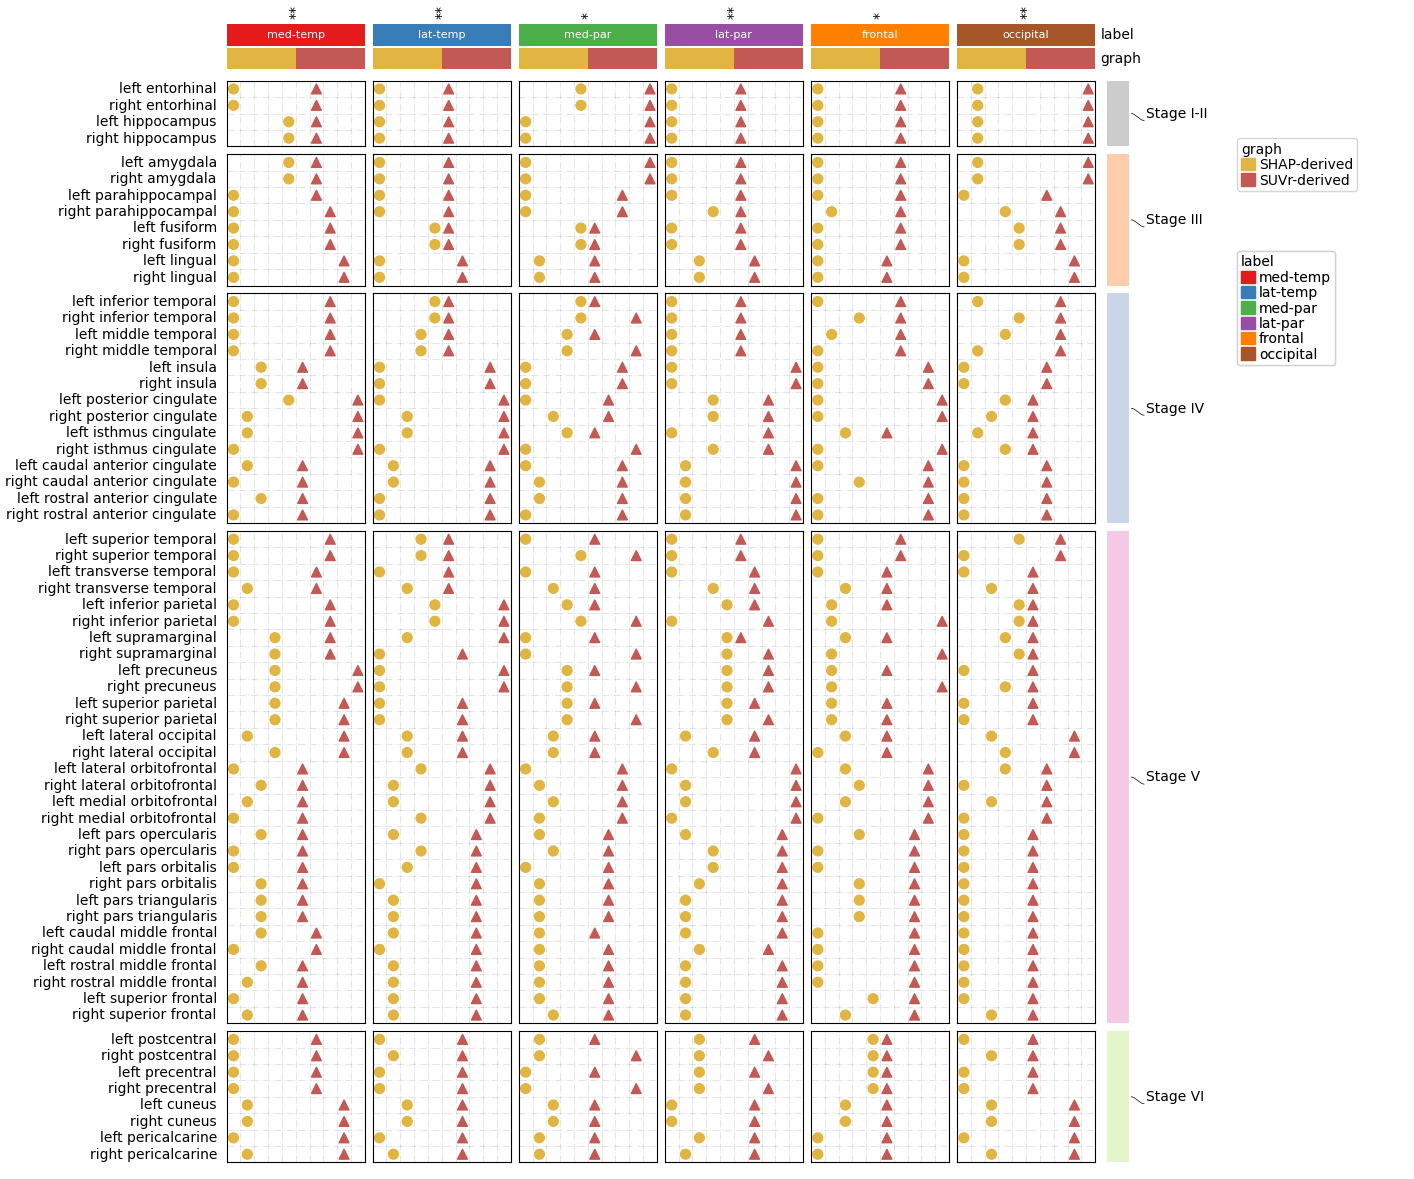

In [31]:
row_ha = HeatmapAnnotation(label=anno_simple(df_row.stage, add_text=False, legend=False, text_kws={'color':'black'},
                                            colors=stage_colors, height=6, legend_kws={'color_text':False}),
                           label0=anno_label(df_row.stage, merge=True, colors='black', rotation=0, height=4, fontsize=10),
                           label_side='top', label_kws={'fontsize':'1', 'color':'white'}, verbose=0, axis=0,
                           hgap=0.5, plot_legend=True)

col_ha = HeatmapAnnotation(label0=anno_label(df_col.star, merge=True, colors='black', rotation=90, height=1, arrowprops=dict(visible=False)),
                           label=anno_simple(df_col.label,colors=label_colors,height=6,legend=True,
                                              add_text=True,text_kws={'color':'white','fontsize':8}, legend_kws={'color_text':False,'fontsize':10}),
                           graph=anno_simple(df_col.graph,colors=approach_colors,height=6,legend=True,
                                                add_text=False,text_kws={'color':'white','fontsize':8},legend_kws=
                                                {'labels':['SHAP-derived','SUVr-derived'],'color_text':False,'fontsize':10}),
                           verbose=0,label_side='right',label_kws={'fontsize':'10', 'color':'black'},
                           hgap=0.5, plot_legend=True)

plt.figure(figsize=(12,15))

cm = DotClustermapPlotter(community_summary_melted_sorted,x='community_full',y='index',value='value',hue='community_full',
              colors=comm_full_colors,marker=comm_full_markers,
              vmax=1,vmin=0,s='value',max_s=50,grid='minor',verbose=0,
              top_annotation=col_ha, right_annotation=row_ha,
              col_split=df_col.label,
              col_split_order=label_names,
              col_cluster=False, row_cluster=False, 
              row_split=df_row.stage, row_split_order=stage_order, row_split_gap=2,
              col_split_gap=2, show_rownames=True, row_names_side='left', show_colnames=False, legend_hpad=2, 
              subplot_gap=3, legend_vpad=30, legend_gap=15, spines=True,
              legend=False)

plt.show()